In [44]:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import pickle
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import gc
import random 
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from  tqdm import tqdm
from logging import StreamHandler, DEBUG, Formatter, FileHandler, getLogger
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "../input/"
path_out = "../output/"

In [2]:
app_train = pd.read_csv(path + "application_train.csv")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
bureau = pd.read_csv(path + "bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
bureau_balance = pd.read_csv(path + "bureau_balance.csv")
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [5]:
credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [6]:
pcb = pd.read_csv(path + "POS_CASH_balance.csv")
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [7]:
previous_application = pd.read_csv(path + "previous_application.csv")
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
installments_payments = pd.read_csv(path + "installments_payments.csv")
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## 学習データ準備

In [18]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

# read the test files 
app_test = pd.read_csv('../input/application_test.csv')

app_test['is_test'] = 1 
app_test['is_train'] = 0
app_train['is_test'] = 0
app_train['is_train'] = 1

# target variable
Y = app_train['TARGET']
train_X = app_train.drop(['TARGET'], axis = 1)

# test ID
test_id = app_test['SK_ID_CURR']
test_X = app_test

# merge train and test datasets for preprocessing
data = pd.concat([train_X, test_X], axis=0)

### カテゴリカルデータ処理

In [19]:
# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

# get categorical features
data_cats = _get_categorical_features(data)
prev_app_cats = _get_categorical_features(previous_application)
bureau_cats = _get_categorical_features(bureau)
pcb_cats = _get_categorical_features(pcb)
ccbal_cats = _get_categorical_features(credit_card_balance)

# create additional dummy features - 
previous_application = _get_dummies(previous_application, prev_app_cats)
bureau = _get_dummies(bureau, bureau_cats)
pcb = _get_dummies(pcb, pcb_cats)
credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

# factorize the categorical features from train and test data
data = _factorize_categoricals(data, data_cats)

## feature engineering

### <a id="1.1">1.1 Feature Engineering - Previous Applications</a>

In [20]:
## More Feature Ideas Reference : https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm 

## count the number of previous applications for a given ID
prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.2">1.2 Feature Engineering - Bureau Data</a>

In [21]:
# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')


### <a id="1.3">1.3 Feature Engineering - Previous Installments</a>

In [22]:
## count the number of previous installments
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## Average values for all other variables in installments payments
avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.4">1.4 Feature Engineering - Pos Cash Balance</a>

In [23]:
### count the number of pos cash for a given ID
pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pcb['SK_ID_PREV'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

## Average Values for all other variables in pos cash
pcb_avg = pcb.groupby('SK_ID_CURR').mean()
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.5">1.5 Feature Engineering - Credit Card Balance </a>

In [24]:
### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.6">1.6 Prepare Final Train and Test data</a>

In [25]:
#### prepare final Train X and Test X dataframes 
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### <a id="2.1">2.1 StratifiedKFold, GridSearch</a>

In [42]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
          'learning_rate': [0.1], 'num_leaves': [16, 32, 48], 'num_iteration': [5000], 'verbose': [0] ,
          'colsample_bytree':[0.8, 0.9], 'subsample':[0.9], 'max_depth':[3,5,7], 'reg_alpha':[0, 0.1], 'reg_lambda':[0.1], 
          'min_split_gain':[0.01], 'min_child_weight':[1]}

max_score = -100
max_params = None

cnt = -1
for params in tqdm(list(ParameterGrid(all_params))):
    list_auc_score = []
    list_logloss_score = []
    list_best_iterations = []
    for train_idx, valid_idx in cv.split(trainX, Y):
        trn_x = trainX.iloc[train_idx, :]
        val_x = trainX.iloc[valid_idx, :]

        trn_y = Y[train_idx]
        val_y = Y[valid_idx]

        lgb_train = lgb.Dataset(data=trn_x, label=trn_y)
        lgb_eval = lgb.Dataset(data=val_x, label=val_y)
    
        model = lgb.train(params, lgb_train,  valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
        pred = model.predict(val_x)

        sc_logloss = log_loss(val_y, pred)
        sc_auc_score =  roc_auc_score(val_y, pred)

        list_logloss_score.append(sc_logloss)
        list_auc_score.append(sc_auc_score)
        list_best_iterations.append(model.best_iteration)


        with open(path_out + 'train_cv_pred_%s.pkl' % cnt, 'wb') as f:
            pickle.dump(pred, f, -1)
        with open(path_out + 'model_%s.pkl' % cnt, 'wb') as f:
            pickle.dump(model, f, -1)
        gc.collect()
        
        params['n_estimators'] = int(np.mean(list_best_iterations))
        sc_logloss = np.mean(list_logloss_score)
        sc_auc_score = np.mean(list_auc_score)
        if sc_auc_score > max_score:
            max_score = sc_auc_score
            max_params = params







  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775297
[400]	valid_0's auc: 0.778016
[600]	valid_0's auc: 0.778811
Early stopping, best iteration is:
[640]	valid_0's auc: 0.778985
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772379
[400]	valid_0's auc: 0.776597
[600]	valid_0's auc: 0.777661
Did not meet early stopping. Best iteration is:
[633]	valid_0's auc: 0.777836
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77571
[400]	valid_0's auc: 0.779476
[600]	valid_0's auc: 0.780566
Did not meet early stopping. Best iteration is:
[582]	valid_0's auc: 0.780676






  3%|██▏                                                                             | 1/36 [03:56<2:17:59, 236.55s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775071
[400]	valid_0's auc: 0.777978
[600]	valid_0's auc: 0.778771
Early stopping, best iteration is:
[580]	valid_0's auc: 0.77895
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.773048
[400]	valid_0's auc: 0.777424
Did not meet early stopping. Best iteration is:
[580]	valid_0's auc: 0.77829
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.7756
[400]	valid_0's auc: 0.779949
Did not meet early stopping. Best iteration is:
[560]	valid_0's auc: 0.781131






  6%|████▍                                                                           | 2/36 [07:37<2:09:31, 228.59s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775297
[400]	valid_0's auc: 0.778016
[600]	valid_0's auc: 0.778811
Early stopping, best iteration is:
[640]	valid_0's auc: 0.778985
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772379
[400]	valid_0's auc: 0.776597
[600]	valid_0's auc: 0.777661
Did not meet early stopping. Best iteration is:
[633]	valid_0's auc: 0.777836
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77571
[400]	valid_0's auc: 0.779476
[600]	valid_0's auc: 0.780566
Did not meet early stopping. Best iteration is:
[582]	valid_0's auc: 0.780676






  8%|██████▋                                                                         | 3/36 [11:33<2:07:07, 231.12s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775071
[400]	valid_0's auc: 0.777978
[600]	valid_0's auc: 0.778771
Early stopping, best iteration is:
[580]	valid_0's auc: 0.77895
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.773048
[400]	valid_0's auc: 0.777424
Did not meet early stopping. Best iteration is:
[580]	valid_0's auc: 0.77829
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.7756
[400]	valid_0's auc: 0.779949
Did not meet early stopping. Best iteration is:
[560]	valid_0's auc: 0.781131






 11%|████████▉                                                                       | 4/36 [15:14<2:01:56, 228.63s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775297
[400]	valid_0's auc: 0.778016
[600]	valid_0's auc: 0.778811
Early stopping, best iteration is:
[640]	valid_0's auc: 0.778985
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772379
[400]	valid_0's auc: 0.776597
[600]	valid_0's auc: 0.777661
Did not meet early stopping. Best iteration is:
[633]	valid_0's auc: 0.777836
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77571
[400]	valid_0's auc: 0.779476
[600]	valid_0's auc: 0.780566
Did not meet early stopping. Best iteration is:
[582]	valid_0's auc: 0.780676






 14%|███████████                                                                     | 5/36 [19:10<1:58:52, 230.07s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775071
[400]	valid_0's auc: 0.777978
[600]	valid_0's auc: 0.778771
Early stopping, best iteration is:
[580]	valid_0's auc: 0.77895
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.773048
[400]	valid_0's auc: 0.777424
Did not meet early stopping. Best iteration is:
[580]	valid_0's auc: 0.77829
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.7756
[400]	valid_0's auc: 0.779949
Did not meet early stopping. Best iteration is:
[560]	valid_0's auc: 0.781131






 17%|█████████████▎                                                                  | 6/36 [22:51<1:54:19, 228.66s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777599
[400]	valid_0's auc: 0.777992
Early stopping, best iteration is:
[328]	valid_0's auc: 0.778501
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776399
Did not meet early stopping. Best iteration is:
[324]	valid_0's auc: 0.77714
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777799
Did not meet early stopping. Best iteration is:
[305]	valid_0's auc: 0.779217






 19%|███████████████▌                                                                | 7/36 [25:59<1:47:39, 222.73s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777072
Early stopping, best iteration is:
[207]	valid_0's auc: 0.777321
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775337
Did not meet early stopping. Best iteration is:
[204]	valid_0's auc: 0.775466
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.778051
Did not meet early stopping. Best iteration is:
[204]	valid_0's auc: 0.778262






 22%|█████████████████▊                                                              | 8/36 [28:25<1:39:28, 213.15s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77664
[400]	valid_0's auc: 0.776403
Early stopping, best iteration is:
[280]	valid_0's auc: 0.77726
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775966
Did not meet early stopping. Best iteration is:
[271]	valid_0's auc: 0.776497
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777376
Did not meet early stopping. Best iteration is:
[260]	valid_0's auc: 0.777925






 25%|████████████████████                                                            | 9/36 [31:31<1:34:34, 210.18s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776573
Early stopping, best iteration is:
[228]	valid_0's auc: 0.777201
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776728
Did not meet early stopping. Best iteration is:
[225]	valid_0's auc: 0.777194
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.778143
Did not meet early stopping. Best iteration is:
[224]	valid_0's auc: 0.778445






 28%|█████████████████████▉                                                         | 10/36 [34:19<1:29:14, 205.93s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77664
[400]	valid_0's auc: 0.776403
Early stopping, best iteration is:
[280]	valid_0's auc: 0.77726
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775966
Did not meet early stopping. Best iteration is:
[271]	valid_0's auc: 0.776497
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777376
Did not meet early stopping. Best iteration is:
[260]	valid_0's auc: 0.777925






 31%|████████████████████████▏                                                      | 11/36 [37:25<1:25:04, 204.18s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776573
Early stopping, best iteration is:
[228]	valid_0's auc: 0.777201
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776728
Did not meet early stopping. Best iteration is:
[225]	valid_0's auc: 0.777194
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.778143
Did not meet early stopping. Best iteration is:
[224]	valid_0's auc: 0.778445






 33%|██████████████████████████▎                                                    | 12/36 [40:13<1:20:27, 201.14s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777584
Early stopping, best iteration is:
[246]	valid_0's auc: 0.778323
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775716
Did not meet early stopping. Best iteration is:
[246]	valid_0's auc: 0.775934
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777517
Did not meet early stopping. Best iteration is:
[202]	valid_0's auc: 0.777659






 36%|████████████████████████████▌                                                  | 13/36 [42:56<1:15:58, 198.18s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777174
Early stopping, best iteration is:
[217]	valid_0's auc: 0.777403
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775862
Did not meet early stopping. Best iteration is:
[202]	valid_0's auc: 0.775886
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.778605
Did not meet early stopping. Best iteration is:
[209]	valid_0's auc: 0.778976






 39%|██████████████████████████████▋                                                | 14/36 [45:30<1:11:30, 195.02s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.774793
Early stopping, best iteration is:
[136]	valid_0's auc: 0.776125
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[133]	valid_0's auc: 0.774545
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[134]	valid_0's auc: 0.776755






 42%|████████████████████████████████▉                                              | 15/36 [47:55<1:07:06, 191.72s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775958
Early stopping, best iteration is:
[148]	valid_0's auc: 0.776318
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[148]	valid_0's auc: 0.773864
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[146]	valid_0's auc: 0.77751






 44%|███████████████████████████████████                                            | 16/36 [50:27<1:03:04, 189.21s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775358
Early stopping, best iteration is:
[134]	valid_0's auc: 0.775891
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[119]	valid_0's auc: 0.773541
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[121]	valid_0's auc: 0.775643






 47%|██████████████████████████████████████▎                                          | 17/36 [53:04<59:19, 187.34s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.774918
Early stopping, best iteration is:
[145]	valid_0's auc: 0.775381
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[145]	valid_0's auc: 0.774481
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[139]	valid_0's auc: 0.775838






 50%|████████████████████████████████████████▌                                        | 18/36 [55:49<55:49, 186.10s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775029
[400]	valid_0's auc: 0.778304
[600]	valid_0's auc: 0.779054
[800]	valid_0's auc: 0.778871
Early stopping, best iteration is:
[658]	valid_0's auc: 0.779243
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772411
[400]	valid_0's auc: 0.776489
[600]	valid_0's auc: 0.777569
Did not meet early stopping. Best iteration is:
[605]	valid_0's auc: 0.777682
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775785
[400]	valid_0's auc: 0.77999
[600]	valid_0's auc: 0.781175
Did not meet early stopping. Best iteration is:
[542]	valid_0's auc: 0.781343






 53%|█████████████████████████████████████████▋                                     | 19/36 [1:00:03<53:44, 189.66s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.774761
[400]	valid_0's auc: 0.7781
[600]	valid_0's auc: 0.778878
[800]	valid_0's auc: 0.779038
[1000]	valid_0's auc: 0.778995
Early stopping, best iteration is:
[854]	valid_0's auc: 0.779203
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772197
[400]	valid_0's auc: 0.776232
[600]	valid_0's auc: 0.777327
[800]	valid_0's auc: 0.7779
Did not meet early stopping. Best iteration is:
[793]	valid_0's auc: 0.778
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77625
[400]	valid_0's auc: 0.780056
[600]	valid_0's auc: 0.781221
Early stopping, best iteration is:
[535]	valid_0's auc: 0.781335






 56%|███████████████████████████████████████████▉                                   | 20/36 [1:05:01<52:01, 195.09s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775029
[400]	valid_0's auc: 0.778304
[600]	valid_0's auc: 0.779054
[800]	valid_0's auc: 0.778871
Early stopping, best iteration is:
[658]	valid_0's auc: 0.779243
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772411
[400]	valid_0's auc: 0.776489
[600]	valid_0's auc: 0.777569
Did not meet early stopping. Best iteration is:
[605]	valid_0's auc: 0.777682
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775785
[400]	valid_0's auc: 0.77999
[600]	valid_0's auc: 0.781175
Did not meet early stopping. Best iteration is:
[542]	valid_0's auc: 0.781343






 58%|██████████████████████████████████████████████                                 | 21/36 [1:09:17<49:29, 197.97s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.774761
[400]	valid_0's auc: 0.7781
[600]	valid_0's auc: 0.778878
[800]	valid_0's auc: 0.779038
[1000]	valid_0's auc: 0.778995
Early stopping, best iteration is:
[854]	valid_0's auc: 0.779203
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772197
[400]	valid_0's auc: 0.776232
[600]	valid_0's auc: 0.777327
[800]	valid_0's auc: 0.7779
Did not meet early stopping. Best iteration is:
[793]	valid_0's auc: 0.778
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77625
[400]	valid_0's auc: 0.780056
[600]	valid_0's auc: 0.781221
Early stopping, best iteration is:
[535]	valid_0's auc: 0.781335






 61%|████████████████████████████████████████████████▎                              | 22/36 [1:14:15<47:15, 202.51s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775029
[400]	valid_0's auc: 0.778304
[600]	valid_0's auc: 0.779054
[800]	valid_0's auc: 0.778871
Early stopping, best iteration is:
[658]	valid_0's auc: 0.779243
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772411
[400]	valid_0's auc: 0.776489
[600]	valid_0's auc: 0.777569
Did not meet early stopping. Best iteration is:
[605]	valid_0's auc: 0.777682
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775785
[400]	valid_0's auc: 0.77999
[600]	valid_0's auc: 0.781175
Did not meet early stopping. Best iteration is:
[542]	valid_0's auc: 0.781343






 64%|██████████████████████████████████████████████████▍                            | 23/36 [1:18:30<44:22, 204.80s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.774761
[400]	valid_0's auc: 0.7781
[600]	valid_0's auc: 0.778878
[800]	valid_0's auc: 0.779038
[1000]	valid_0's auc: 0.778995
Early stopping, best iteration is:
[854]	valid_0's auc: 0.779203
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.772197
[400]	valid_0's auc: 0.776232
[600]	valid_0's auc: 0.777327
[800]	valid_0's auc: 0.7779
Did not meet early stopping. Best iteration is:
[793]	valid_0's auc: 0.778
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77625
[400]	valid_0's auc: 0.780056
[600]	valid_0's auc: 0.781221
Early stopping, best iteration is:
[535]	valid_0's auc: 0.781335






 67%|████████████████████████████████████████████████████▋                          | 24/36 [1:23:29<41:44, 208.73s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776895
[400]	valid_0's auc: 0.777282
Early stopping, best iteration is:
[258]	valid_0's auc: 0.777556
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776121
Did not meet early stopping. Best iteration is:
[254]	valid_0's auc: 0.776766
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77862
Did not meet early stopping. Best iteration is:
[256]	valid_0's auc: 0.779339






 69%|██████████████████████████████████████████████████████▊                        | 25/36 [1:26:24<38:01, 207.38s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776883
[400]	valid_0's auc: 0.777504
Early stopping, best iteration is:
[316]	valid_0's auc: 0.77765
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77589
Did not meet early stopping. Best iteration is:
[316]	valid_0's auc: 0.777083
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.778716
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.779576






 72%|█████████████████████████████████████████████████████████                      | 26/36 [1:29:41<34:29, 206.98s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776622
[400]	valid_0's auc: 0.775844
Early stopping, best iteration is:
[305]	valid_0's auc: 0.776892
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77518
Did not meet early stopping. Best iteration is:
[286]	valid_0's auc: 0.77628
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777206
Did not meet early stopping. Best iteration is:
[294]	valid_0's auc: 0.778004






 75%|███████████████████████████████████████████████████████████▎                   | 27/36 [1:33:10<31:03, 207.05s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776918
[400]	valid_0's auc: 0.77613
Early stopping, best iteration is:
[273]	valid_0's auc: 0.777525
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776025
Did not meet early stopping. Best iteration is:
[271]	valid_0's auc: 0.776492
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77853
Did not meet early stopping. Best iteration is:
[271]	valid_0's auc: 0.778968






 78%|█████████████████████████████████████████████████████████████▍                 | 28/36 [1:36:28<27:33, 206.72s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776622
[400]	valid_0's auc: 0.775844
Early stopping, best iteration is:
[305]	valid_0's auc: 0.776892
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77518
Did not meet early stopping. Best iteration is:
[286]	valid_0's auc: 0.77628
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777206
Did not meet early stopping. Best iteration is:
[294]	valid_0's auc: 0.778004






 81%|███████████████████████████████████████████████████████████████▋               | 29/36 [1:39:57<24:07, 206.80s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776918
[400]	valid_0's auc: 0.77613
Early stopping, best iteration is:
[273]	valid_0's auc: 0.777525
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776025
Did not meet early stopping. Best iteration is:
[271]	valid_0's auc: 0.776492
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77853
Did not meet early stopping. Best iteration is:
[271]	valid_0's auc: 0.778968






 83%|█████████████████████████████████████████████████████████████████▊             | 30/36 [1:43:14<20:38, 206.48s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77689
[400]	valid_0's auc: 0.776363
Early stopping, best iteration is:
[266]	valid_0's auc: 0.777371
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775548
Did not meet early stopping. Best iteration is:
[240]	valid_0's auc: 0.77577
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.778223
Did not meet early stopping. Best iteration is:
[253]	valid_0's auc: 0.778434






 86%|████████████████████████████████████████████████████████████████████           | 31/36 [1:46:11<17:07, 205.54s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777377
[400]	valid_0's auc: 0.777298
Early stopping, best iteration is:
[252]	valid_0's auc: 0.777767
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775861
Did not meet early stopping. Best iteration is:
[233]	valid_0's auc: 0.776236
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.777347
Did not meet early stopping. Best iteration is:
[223]	valid_0's auc: 0.777916






 89%|██████████████████████████████████████████████████████████████████████▏        | 32/36 [1:49:04<13:38, 204.53s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.77678
Early stopping, best iteration is:
[134]	valid_0's auc: 0.777196
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[125]	valid_0's auc: 0.77488
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[116]	valid_0's auc: 0.777794






 92%|████████████████████████████████████████████████████████████████████████▍      | 33/36 [1:51:37<10:08, 202.96s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776166
Early stopping, best iteration is:
[146]	valid_0's auc: 0.776665
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[144]	valid_0's auc: 0.775912
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[129]	valid_0's auc: 0.777219






 94%|██████████████████████████████████████████████████████████████████████████▌    | 34/36 [1:54:17<06:43, 201.69s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.774874
Early stopping, best iteration is:
[133]	valid_0's auc: 0.775551
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[129]	valid_0's auc: 0.774751
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[124]	valid_0's auc: 0.775554






 97%|████████████████████████████████████████████████████████████████████████████▊  | 35/36 [1:57:05<03:20, 200.74s/it]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775586
Early stopping, best iteration is:
[136]	valid_0's auc: 0.776409
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[136]	valid_0's auc: 0.775006
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[126]	valid_0's auc: 0.77605






100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [1:59:55<00:00, 199.88s/it]





NameError: name 'logger' is not defined

In [45]:
##############

trees = np.mean(list_best_iterations)

all_lgb_train = lgb.Dataset(data=trainX, label=Y)
print('train start')
clf = lgb.train(max_params,
                all_lgb_train,
                    int(trees * 1.1),
                    valid_sets=[all_lgb_train],
                    verbose_eval=10
                    )
print('train end')
with open(path_out + 'model.pkl', 'wb') as f:
    pickle.dump(clf, f, -1)

print('save end')
        

train start
[10]	training's auc: 0.722831
[20]	training's auc: 0.737489
[30]	training's auc: 0.750388
[40]	training's auc: 0.7581
[50]	training's auc: 0.76381
[60]	training's auc: 0.768171
[70]	training's auc: 0.771287
[80]	training's auc: 0.774067
[90]	training's auc: 0.776199
[100]	training's auc: 0.778097
[110]	training's auc: 0.779913
[120]	training's auc: 0.781463
[130]	training's auc: 0.782937
[140]	training's auc: 0.784174
[150]	training's auc: 0.785325
[160]	training's auc: 0.78653
[170]	training's auc: 0.78776
[180]	training's auc: 0.788868
[190]	training's auc: 0.789803
[200]	training's auc: 0.790705
[210]	training's auc: 0.791693
[220]	training's auc: 0.792609
[230]	training's auc: 0.793487
[240]	training's auc: 0.794192
[250]	training's auc: 0.794915
[260]	training's auc: 0.795665
[270]	training's auc: 0.796516
[280]	training's auc: 0.797304
[290]	training's auc: 0.797991
[300]	training's auc: 0.798678
[310]	training's auc: 0.799243
[320]	training's auc: 0.799835
[330]	trai

### <a id="4.1">4.1 Feature Importance </a>

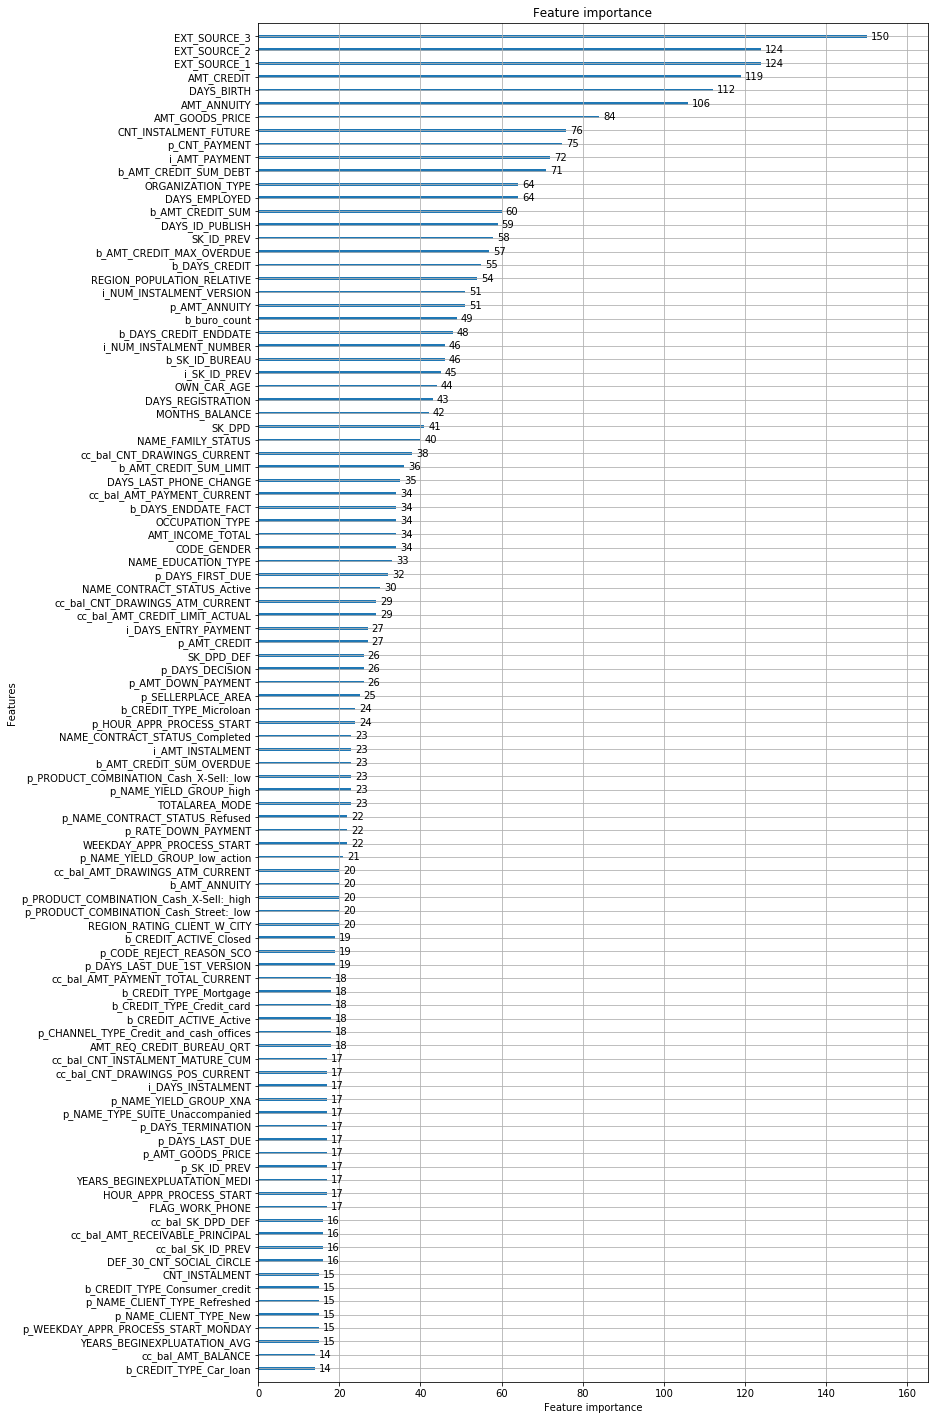

In [46]:
lgb.plot_importance(clf, figsize=(12, 25), max_num_features=100);


### <a id="5.1">5.1 Predict</a>

In [49]:
preds = clf.predict(testX)
    
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("../output/2_lgbm_submit.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.050009
1,100005,0.153704
2,100013,0.015793
3,100028,0.040926
4,100038,0.147716


In [ ]:
    tkm_all_params = {
        'learning_rate': 0.1,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        #'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight': 99,  # because training data is extremely unbalanced
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
    }